# Introduction to scvi-tools

In this introductory tutorial, we go through the different steps of an scvi-tools workflow.

While we focus on scVI in this tutorial, the API is consistent across all models.

In [1]:
import scanpy as sc
import scvi
import anndata as ad
import pandas as pd
import matplotlib.pyplot as plt
import torch
import numpy

sc.set_figure_params(figsize=(4, 4))

# for white background of figures (only for docs rendering)
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

/home/owkin/deepdeconv/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/home/owkin/deepdeconv/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
/home/owkin/.conda/envs/scvi/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Loading and preparing data

#### Cross-tissue immune cell analysis reveals tissue-specific features in humans - Global

Despite their crucial role in health and disease, our knowledge of immune cells within human tissues remains limited. We surveyed the immune compartment of 16 tissues from 12 adult donors by single-cell RNA sequencing and VDJ sequencing generating a dataset of ~360,000 cells. To systematically resolve immune cell heterogeneity across tissues, we developed CellTypist, a machine learning tool for rapid and precise cell type annotation. Using this approach, combined with detailed curation, we determined the tissue distribution of finely phenotyped immune cell types, revealing hitherto unappreciated tissue-specific features and clonal architecture of T and B cells. Our multitissue approach lays the foundation for identifying highly resolved immune cell types by leveraging a common reference dataset, tissue-integrated expression analysis, and antigen receptor sequencing.

```{important}
All scvi-tools models require AnnData objects as input.
```

In [2]:
## Toy dataset 
#adata = ad.read_h5ad("/home/owkin/data/cross-tissue/omics/raw/local.h5ad")
# adata = scvi.data.heart_cell_atlas_subsampled()

## Cross-immune 
adata = sc.read("/home/owkin/data/cross-tissue/omics/raw/local.h5ad")

adata

AnnData object with n_obs × n_vars = 329762 × 36503
    obs: 'donor_id', 'Predicted_labels_CellTypist', 'Majority_voting_CellTypist', 'Majority_voting_CellTypist_high', 'Manually_curated_celltype', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'suspension_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage'
    var: 'gene_symbols', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype'
    uns: 'cell_type_ontology_term_id_colors', 'default_embedding', 'development_stage_ontology_term_id_colors', 'schema_version', 'sex_ontology_term_id_colors', 'title'
    obsm: 'X_umap'

In [3]:
adata.obs["cell_type"].value_counts()

cell_type
naive thymus-derived CD4-positive, alpha-beta T cell                          37613
memory B cell                                                                 30124
CD8-positive, alpha-beta memory T cell                                        25519
classical monocyte                                                            21847
CD16-positive, CD56-dim natural killer cell, human                            20591
effector memory CD4-positive, alpha-beta T cell                               19869
alveolar macrophage                                                           17238
CD4-positive helper T cell                                                    16099
T follicular helper cell                                                      15293
effector memory CD8-positive, alpha-beta T cell, terminally differentiated    14612
naive B cell                                                                  13998
CD8-positive, alpha-beta memory T cell, CD45RO-positive           

Now we preprocess the data to remove, for example, genes that are very lowly expressed and other outliers. For these tasks we prefer the [Scanpy preprocessing module](https://scanpy.readthedocs.io/en/stable/api/index.html#module-scanpy.pp).

In [55]:
sc.pp.filter_genes(adata, min_counts=3)

In scRNA-seq analysis, it's popular to normalize the data. These values are not used by scvi-tools, but given their popularity in other tasks as well as for visualization, we store them in the anndata object separately (via the `.raw` attribute).

```{important}
Unless otherwise specified, scvi-tools models require the raw counts (not log library size normalized). scvi-tools models will run for non-negative real-valued data, but we strongly suggest checking that these possibly non-count values are intended to represent pseudocounts (e.g. SoupX-corrected counts), and not some other normalized data, in which the variance/covariance structure of the data has changed dramatically.
```

In [56]:
adata.layers["counts"] = adata.X.copy()  # preserve counts
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata  # freeze the state in `.raw`

Finally, we perform feature selection, to reduce the number of features (genes in this case) used as input to the scvi-tools model. For best practices of how/when to perform feature selection, please refer to the model-specific tutorial. For scVI, we recommend anywhere from 1,000 to 10,000 HVGs, but it will be context-dependent.

In [57]:
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=1200,
    subset=True,
    layer="counts",
    flavor="seurat_v3",
    batch_key="cell_source",
)

Now it's time to run `setup_anndata()`, which alerts scvi-tools to the locations of various matrices inside the anndata. It's important to run this function with the correct arguments so scvi-tools is notified that your dataset has batches, annotations, etc. For example, if batches are registered with scvi-tools, the subsequent model will correct for batch effects. See the full documentation for details.

In this dataset, there is a "cell_source" categorical covariate, and within each "cell_source", multiple "donors", "gender" and "age_group". There are also two continuous covariates we'd like to correct for: "percent_mito" and "percent_ribo". These covariates can be registered using the `categorical_covariate_keys` argument. If you only have one categorical covariate, you can also use the `batch_key` argument instead.

In [58]:
scvi.model.SCVI.setup_anndata(
    adata,
    layer="counts",
    categorical_covariate_keys=["cell_source", "donor"],
    continuous_covariate_keys=["percent_mito", "percent_ribo"],
)

In [104]:
scvi.model.CondSCVI.setup_anndata(adata,
                                  layer="counts",
                                  labels_key="cell_type",
)

```{warning}
If the adata is modified after running `setup_anndata`, please run `setup_anndata` again, before creating an instance of a model.
```

## Creating and training a model

While we highlight the scVI model here, the API is consistent across all scvi-tools models and is inspired by that of [scikit-learn](https://scikit-learn.org/stable/). For a full list of options, see the scvi [documentation](https://scvi-tools.org).

In [60]:
model = scvi.model.SCVI(adata)

# model.view_anndata_setup()

SCVI Model with the following params: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, gene_likelihood: zinb, 
latent_distribution: normal
Training status: Not Trained
Model's adata is minified?: False

In [ ]:
model.train(max_epochs=100)

```{important}
All scvi-tools models run faster when using a GPU. By default, scvi-tools will use a GPU if one is found to be available. Please see the installation page for more information about installing scvi-tools when a GPU is available.
```

In [105]:
model_cond = scvi.model.CondSCVI(adata, weight_obs=True)

model_cond.view_anndata_setup()

Anndata setup with scvi-tools version 1.0.0.

Setup via `CondSCVI.setup_anndata` with arguments:

{'labels_key': 'cell_type', 'layer': 'counts'}

     Summary Statistics     
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Summary Stat Key ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│     n_cells      │ 18641 │
│     n_labels     │  11   │
│      n_vars      │ 1200  │
└──────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │  adata.layers['counts']   │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                           labels State Registry                            
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location     ┃        Categories         ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['cell_type'] │        Adipocytes         │          0          │
│                        │   Atrial_Cardiomyocyte    │          1          │
│                        │        Endothelial        │          2          │
│                        │        Fibroblast         │          3          │
│                        │         Lymphoid          │          4          │
│                        │        Mesothelial        │          5          │
│                        │          Myeloid          │          6          │
│                        │         Neuronal          │          7          │
│                        │         Pericytes         │          8          │
│                        │    Smooth_muscle_cells    │          9          │
│                        │ Ventricular_Cardiomyocyte │         10          │
└────────────────────────┴───────────────────────────┴─────────────────────┘

In [106]:
model_cond.train(max_epochs=100)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 100/100: 100%|██████████| 100/100 [02:46<00:00,  1.65s/it, v_num=1, train_loss_step=3.33e+3, train_loss_epoch=2.84e+3]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████| 100/100 [02:46<00:00,  1.67s/it, v_num=1, train_loss_step=3.33e+3, train_loss_epoch=2.84e+3]


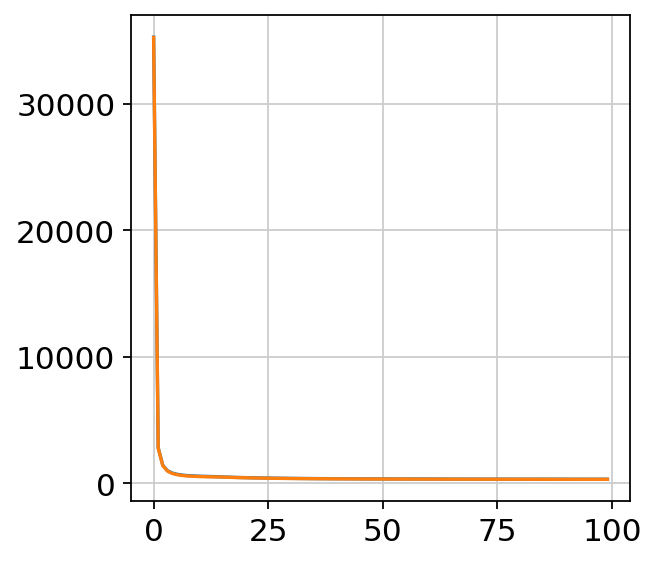

In [107]:
plt.plot(model_cond.history["elbo_train"])
plt.plot(model_cond.history["reconstruction_loss_train"])

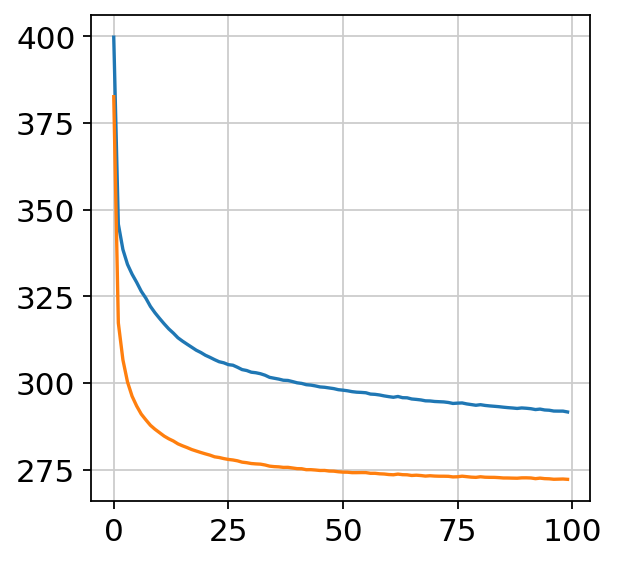

In [108]:
plt.plot(model.history["elbo_train"])
plt.plot(model.history["reconstruction_loss_train"])

### Saving and loading

Saving consists of saving the model neural network weights, as well as parameters used to initialize the model.

In [11]:
# model.save("my_model/")

In [12]:
# model = scvi.model.SCVI.load("my_model/", adata=adata, use_gpu=True)

## Latent space

In [109]:
# Regular scVI
latent = model.get_latent_representation()
adata.obsm["X_scVI"] = latent

latent.shape

(18641, 10)

In [110]:
# CondscVI
latent_cond = model_cond.get_latent_representation()
adata.obsm["X_condSCVI"] = latent_cond

latent_cond.shape

(18641, 5)

## 2D Embedding plots

#### scVI latent space 

/home/owkin/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


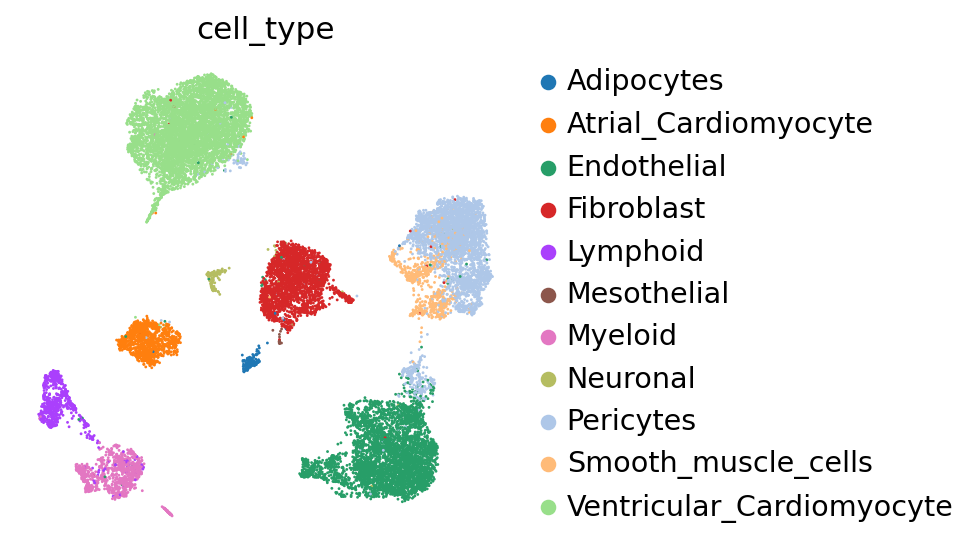

/home/owkin/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/owkin/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


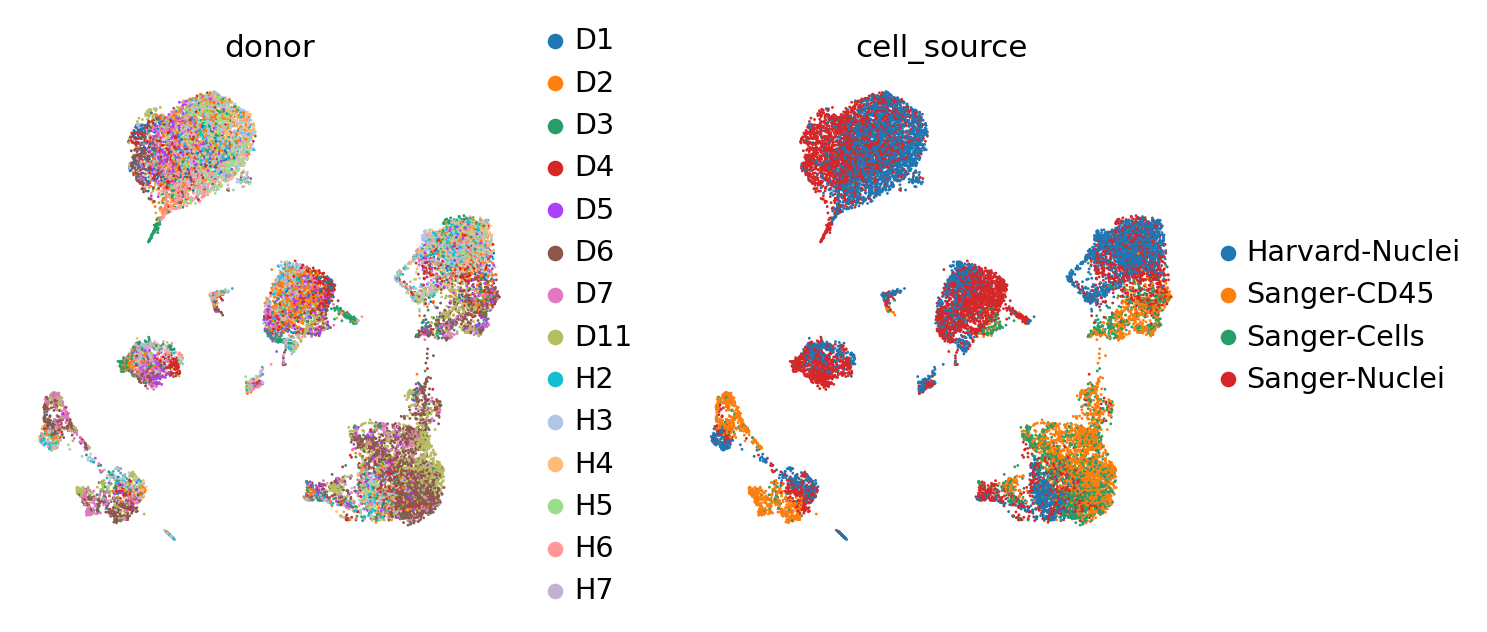

In [111]:
# run PCA then generate UMAP plots
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata, min_dist=0.3)

sc.pl.umap(
    adata,
    color=["cell_type"],
    frameon=False,
)
sc.pl.umap(
    adata,
    color=["donor", "cell_source"],
    ncols=2,
    frameon=False,
)


#### condSCVI latent space 

/home/owkin/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


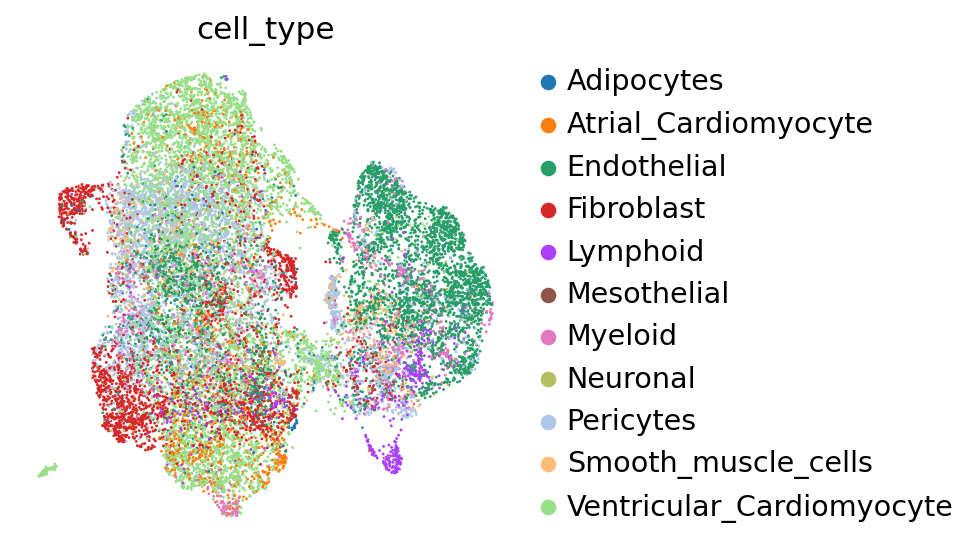

/home/owkin/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/owkin/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


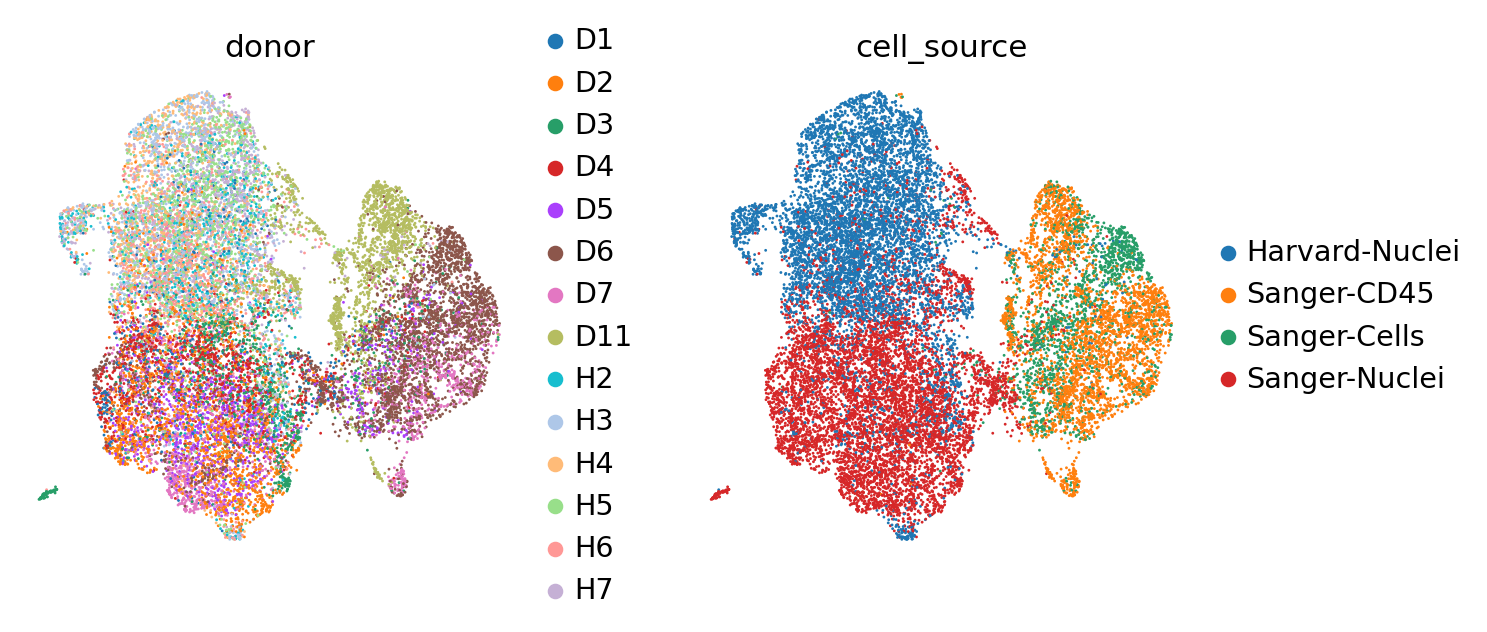

In [112]:
# run PCA then generate UMAP plots
sc.pp.neighbors(adata, use_rep="X_condSCVI")
sc.tl.umap(adata, min_dist=0.3)

sc.pl.umap(
    adata,
    color=["cell_type"],
    frameon=False,
)
sc.pl.umap(
    adata,
    color=["donor", "cell_source"],
    ncols=2,
    frameon=False,
)

The `model.get...()` functions default to using the anndata that was used to initialize the model. It's possible to also query a subset of the anndata, or even use a completely independent anndata object as long as the anndata is organized in an equivalent fashion.

We will use it to compute the **mean gene expression vector for each cell type present in the dataset** .

## Create Signature matrix

scVI

In [134]:
# Denoised signature computation

df_signature_denoised = pd.DataFrame()

for cell_type in adata.obs["cell_type"].unique():
    indices = adata[adata.obs.cell_type == cell_type].obs.index
    integer_indices = adata.obs.index.get_indexer(indices)
    # latent_subset = model.get_latent_representation(adata_subset)
    denoised = model.get_normalized_expression(indices=integer_indices,
                                               library_size=1e4)
    df = denoised.mean(axis=0).to_frame()
    df.columns = [cell_type]
    df_signature_denoised = pd.concat([df_signature_denoised, df], axis=1)

In [135]:
df_signature_denoised.head()

,Myeloid,Ventricular_Cardiomyocyte,Fibroblast,Endothelial,Adipocytes,Pericytes,Atrial_Cardiomyocyte,Smooth_muscle_cells,Neuronal,Lymphoid,Mesothelial
ISG15,17.282846,0.744812,1.995698,26.071238,0.460007,7.114202,0.878397,9.209705,3.147564,25.285997,3.830830
TNFRSF18,0.517210,0.061163,0.188310,0.241353,0.291365,0.043274,0.067161,0.073111,0.284127,5.051686,0.226357
VWA1,0.337138,0.124752,1.925600,3.927401,1.100398,0.461712,0.308225,0.474513,16.125858,0.717883,4.539732
HES5,0.032729,0.055502,0.094523,1.417326,0.071055,0.420414,0.017360,0.126217,0.139575,0.018227,0.089738
SPSB1,0.598876,2.116964,9.193729,1.504519,8.944302,3.114868,1.329408,1.912425,5.004593,0.790201,5.231209


condSCVI

In [131]:
# Denoised signature computation

# df_signature_cond_denoised = pd.DataFrame()

# for cell_type in adata.obs["cell_type"].unique():
#     indices = adata[adata.obs.cell_type == cell_type].obs.index
#     integer_indices = adata.obs.index.get_indexer(indices)
#     # latent_subset = model.get_latent_representation(adata_subset)
#     denoised = model_cond.get_normalized_expression(adata,
#                                                     indices=integer_indices,
#                                                     library_size=1e4)
                                                
                                               
#     df = denoised.mean(axis=0).to_frame()
#     df.columns = [cell_type]
#     df_signature_cond_denoised = pd.concat([df_signature_cond_denoised, df], axis=1)

Vanilla signature matrix

In [136]:
X_norm = sc.pp.normalize_total(adata,
                               target_sum=1e4,
                               layer="counts",
                               inplace=False)['X']



In [139]:
df_signature = pd.DataFrame()

for cell_type in adata.obs["cell_type"].unique():
    indices = adata[adata.obs.cell_type == cell_type].obs.index
    integer_indices = adata.obs.index.get_indexer(indices)
    df = pd.DataFrame(X_norm[integer_indices, :].mean(axis=0).T,
             index=adata.var_names,
             columns=[cell_type])
    df_signature = pd.concat([df_signature, df], axis=1) 

In [140]:
df_signature_denoised.head()

,Myeloid,Ventricular_Cardiomyocyte,Fibroblast,Endothelial,Adipocytes,Pericytes,Atrial_Cardiomyocyte,Smooth_muscle_cells,Neuronal,Lymphoid,Mesothelial
ISG15,17.282846,0.744812,1.995698,26.071238,0.460007,7.114202,0.878397,9.209705,3.147564,25.285997,3.830830
TNFRSF18,0.517210,0.061163,0.188310,0.241353,0.291365,0.043274,0.067161,0.073111,0.284127,5.051686,0.226357
VWA1,0.337138,0.124752,1.925600,3.927401,1.100398,0.461712,0.308225,0.474513,16.125858,0.717883,4.539732
HES5,0.032729,0.055502,0.094523,1.417326,0.071055,0.420414,0.017360,0.126217,0.139575,0.018227,0.089738
SPSB1,0.598876,2.116964,9.193729,1.504519,8.944302,3.114868,1.329408,1.912425,5.004593,0.790201,5.231209


In [141]:
df_signature.head()

,Myeloid,Ventricular_Cardiomyocyte,Fibroblast,Endothelial,Adipocytes,Pericytes,Atrial_Cardiomyocyte,Smooth_muscle_cells,Neuronal,Lymphoid,Mesothelial
ISG15,18.575951,0.696455,1.575502,25.316034,0.443830,6.936509,0.854068,7.743858,4.402905,24.493906,4.690090
TNFRSF18,0.231079,0.003992,0.004373,0.102777,0.125964,0.000000,0.000000,0.000000,0.000000,4.453959,0.000000
VWA1,0.044702,0.057687,1.151737,3.990896,0.481120,0.332836,0.037399,0.272288,19.431240,0.171176,0.000000
HES5,0.000000,0.039024,0.000000,0.935358,0.000000,0.154359,0.029322,0.000000,0.000000,0.000000,0.000000
SPSB1,0.230131,0.667728,9.387855,1.271429,6.820549,3.048096,1.527574,0.927425,5.304519,0.346744,0.582988


In [208]:
import seaborn as sns 
from scipy.stats import spearmanr, pearsonr

In [ ]:
marker_genes = {"Endothelial": ["EGFL7", "VWF", "SLC9A3R2"],
                "Neuronal": ["NRXN1", "GPM6B", "L1CAM"],
                "Atrial_Cardiomyocyte": ["SYNPR", "MYL7", "KCNJ3"],
                "Mesothelial": ["KRT19", "PRG4", "UPK3B"], 
                "Ventricular_Cardiomyocyte": ["C15orf41", "GALTN17", "FYB2"],
                "Lymphoid" : ["IL7R", "CD2", "GZMA"],
                "Myeloid": ["MS4A6A", "SPI1", "MS4A6A"],
                "Pericytes": ["HIGD1B", "RGS5", "NOTCH3"],
                "Smooth_muscle_cells": ["WFDC1", "MYH11", "ACTG2"],
                "Adipocytes": ["CIDEC", "ADIPOQ", "GPAM"],
                "Fibroblast": ["CDH19", "MGST1", "FBN1"]
                }

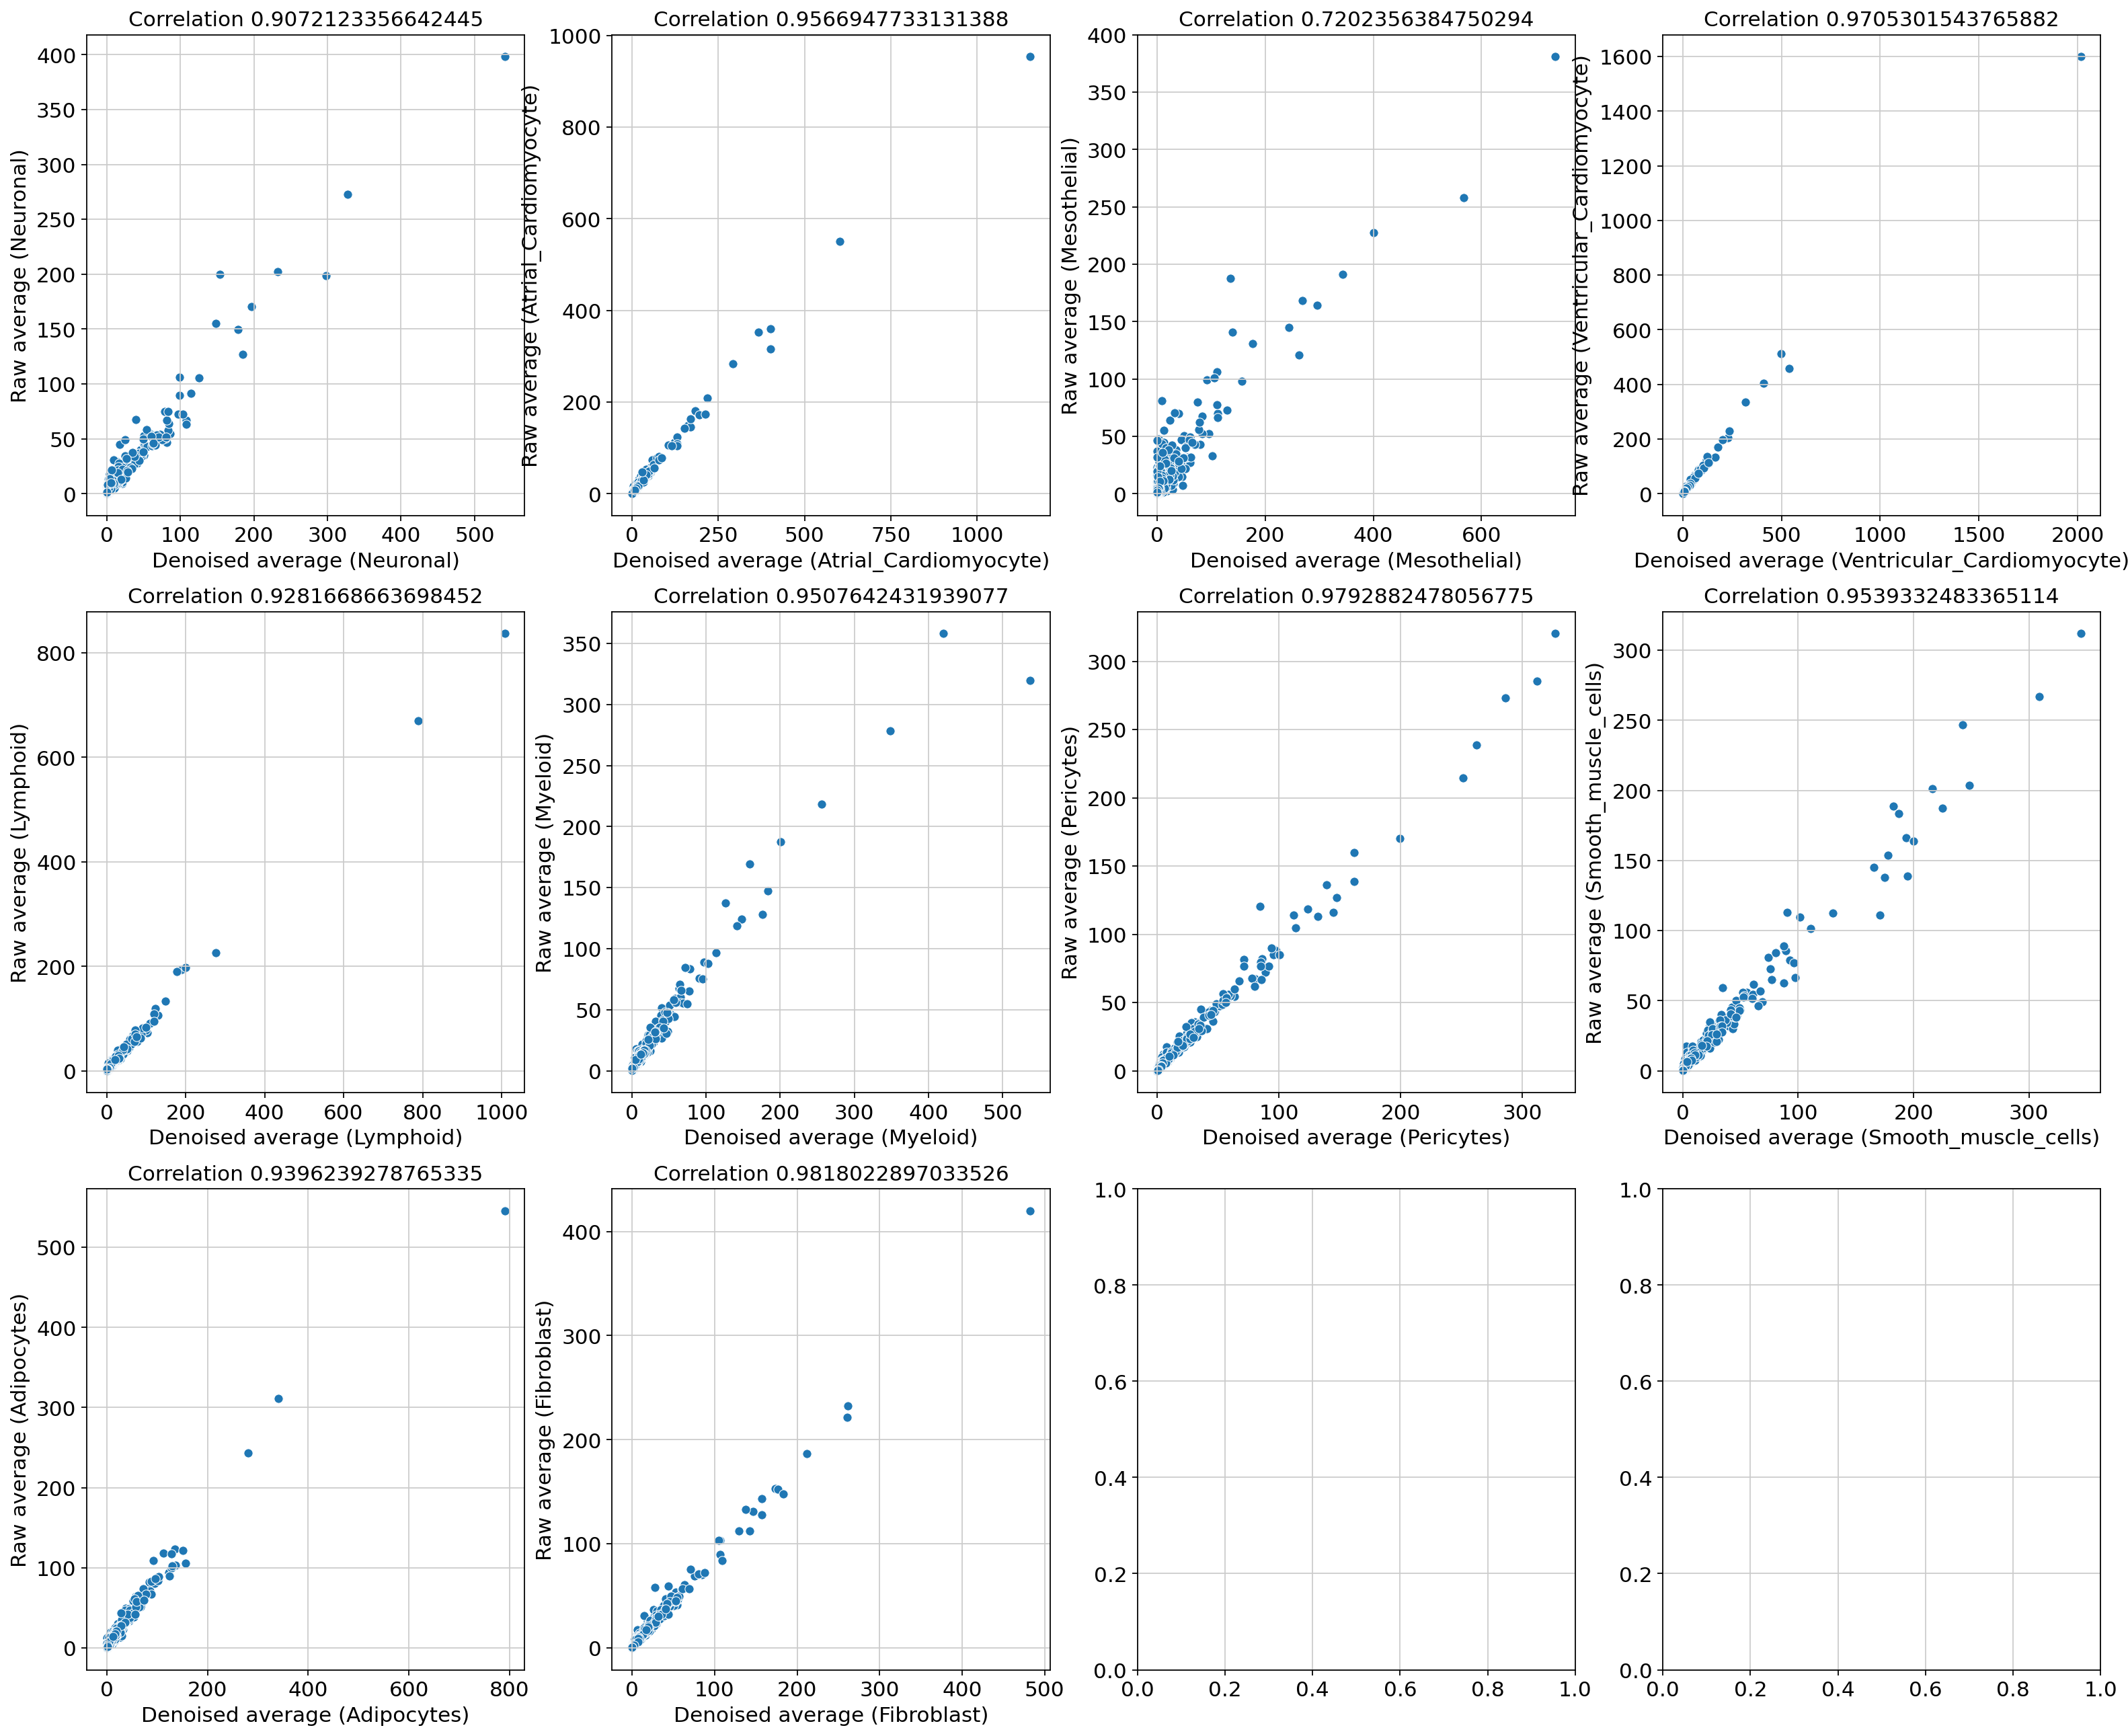

In [175]:
cell_types = list(marker_genes.keys())

h = 0
n_rows = 3
n_cols = 4

fig, ax = plt.subplots(n_rows, n_cols, figsize=(24, 20))

for i in range(n_rows):
    for j in range(n_cols):
        h += 1
        if h == len(marker_genes):
            break
        cell_type = cell_types[h]
        x_raw = df_signature[cell_type].values
        x_denoised = df_signature_denoised[cell_type].values
        # keep_genes = pd.Index(list(set(marker_genes[cell_type]) & set(adata.var_names)))
        # x_raw = df_signature.loc[keep_genes][cell_type].values
        # x_denoised = df_signature_denoised.loc[keep_genes][cell_type].values
        corr = spearmanr(x_raw, x_denoised)[0]
        
        sns.scatterplot(x=x_raw,
                        y=x_denoised,
                        ax=ax[i][j]
                        )
        ax[i][j].set_xlabel(f"Denoised average ({cell_type})")
        ax[i][j].set_ylabel(f"Raw average ({cell_type})")
        ax[i][j].set_title(f"Correlation {corr}")
        


### scVI latent space linearity hypothesis

In [179]:
adata.obs["cell_type"].value_counts(normalize=True)

cell_type
Ventricular_Cardiomyocyte    0.284695
Endothelial                  0.220428
Pericytes                    0.171879
Fibroblast                   0.131216
Atrial_Cardiomyocyte         0.054128
Myeloid                      0.051338
Lymphoid                     0.035030
Smooth_muscle_cells          0.034387
Neuronal                     0.008208
Adipocytes                   0.007779
Mesothelial                  0.000912
Name: proportion, dtype: float64

In [289]:
N = 10
# Define the number of cells you want to sample

batch_size = [32, 64, 128, 256, 512, 1024, 2048, 4096, 8192] 

corrs = []
p_values = []

for n in batch_size:
    # Calculate the number of cells to sample from each cell type proportionally
    sampled_cells_per_type = adata.obs['cell_type'].value_counts(normalize=True) * n
    sampled_cells_per_type = sampled_cells_per_type.astype(int)

    # Perform stratified sampling for each cell type
    sampled_cells = []
    for cell_type, num_cells in sampled_cells_per_type.items():
        sampled_cells.extend(adata.obs[adata.obs['cell_type'] == cell_type].sample(n=num_cells,
                                                                                random_state=42).index)

    # print(sampled_cells)
    # Select the sampled cells from the DataFrame
    adata_sampled = adata[sampled_cells]

    # embeddings of single-cells
    #latent_sampled = model.get_latent_representation(adata_sampled)
    latent_sampled = model.module.z_encoder(torch.from_numpy(adata.layers["counts"].toarray()).to("cuda:0"))[1]
    latent_sampled = latent_sampled.detach().cpu().numpy()
    mean_sampled = latent_sampled.sum(axis=0)

    # pseudo-bulk embedding
    mean_x = adata_sampled.layers["counts"].sum(axis=0) #.astype(int).astype(numpy.float32)
    mean_z = model.module.z_encoder(torch.from_numpy(mean_x).to("cuda:0"))[1]
    mean_z = mean_z.detach().cpu().numpy().flatten()
    
    # Compute correlation
    pearson_corr = pearsonr(mean_sampled, mean_z)
    #print(pearson_corr[0], pearson_corr[1])
    corrs.append(pearson_corr[0])
    p_values.append(pearson_corr[1])

Text(0.5, 1.0, 'Sanity check 0: correlation between sum(encodings)~=encoder(pseudo-bulk)')

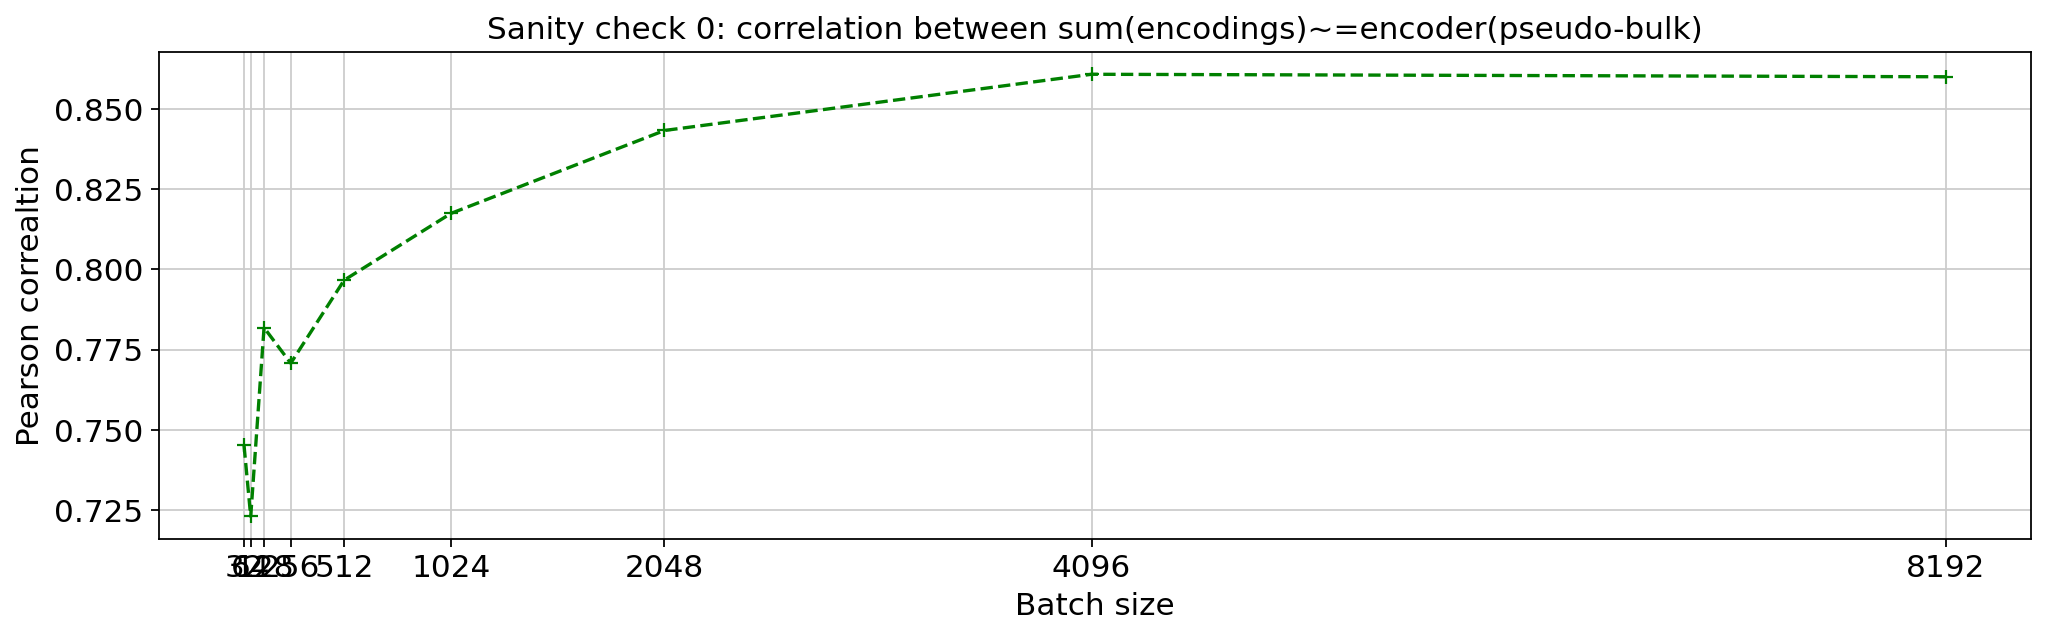

In [290]:
fig, ax = plt.subplots(1, 1, figsize=(15, 4))

plt.plot(batch_size, corrs, color="green", linestyle="--", marker="+")
plt.xlabel("Batch size")
plt.ylabel("Pearson correaltion")
plt.xticks(batch_size)
plt.title("Sanity check 0: correlation between sum(encodings)~=encoder(pseudo-bulk)")

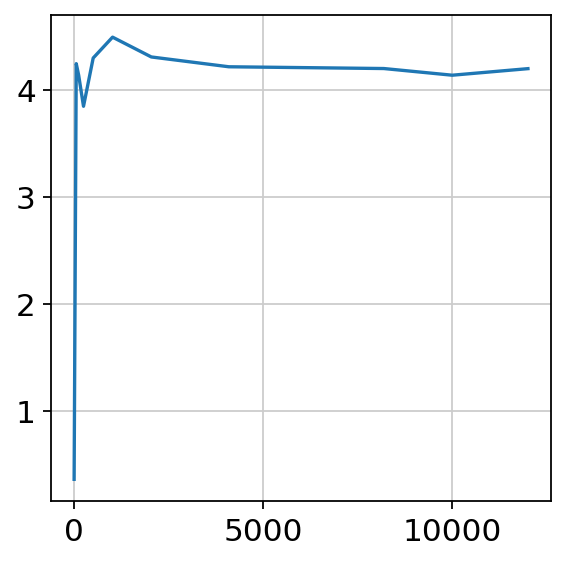

In [262]:
plt.plot(batch_size, -1 * numpy.log(p_values))